<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Importing Landlab output into Blender

*(This tutorial was written as a collaboration between geology professor Greg Tucker and Vancouver-based visual effects artist Rees Tucker. First version August 2023.)*

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

[Blender](https://www.blender.org/) is a free and open source 3D computer graphics software package. The Blender developers' vision is that "Everyone should be free to create 3D CG content, with free technical and creative production means and free access to markets." This tutorial describes the basics of getting Landlab output into Blender, using the Wavefront .obj output format.

## Creating a Landlab model as an example

...

Begin with some imports:

In [1]:
import numpy as np

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    DepthDependentTaylorDiffuser,
    ExponentialWeatherer,
    FlowAccumulator,
    SpaceLargeScaleEroder,
)
from landlab.io.obj import write_obj

In [2]:
# Parameters
nrows = 100  # number of node rows
ncols = 160  # number of node columns
dx = 10.0  # grid node spacing, m
max_soil_prod_rate = 0.001  # maximum soil production rate, m/y
soil_prod_decay_depth = 0.5  # decay depth for soil production, m
soil_transport_velocity = 0.02  # transport coefficient for soil creep, m/y
slope_crit = 1.0  # threshold slope factor for soil cree, -
soil_transport_decay_depth = 0.5  # decay depth for transport rate, m
nterms = 2  # number of terms for diffusion equation
K_sed = 0.001  # erosion coefficient for sediment
K_br = 0.0001  # erosion coefficient for rock
nsteps = 200  # number of time steps
dt = 10.0  # time-step duration, years
base_output_name = "eroding_landscape"  # base name for output files
output_interval = 100.0  # interval for output, y
fields_to_output = [
    "topographic__elevation",
    "soil__depth",
    "bedrock__elevation",
    "soil_production__rate",
    "drainage_area",
    "surface_water__discharge",
    "topographic__steepest_slope",
    "sediment__influx",
    "sediment__outflux",
]

In [3]:
# Create the grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)

# Create input fields
elev = grid.add_zeros("topographic__elevation", at="node")
soil = grid.add_zeros("soil__depth", at="node")
rock = grid.add_zeros("bedrock__elevation", at="node")

In [4]:
# Instantiate components
weatherer = ExponentialWeatherer(grid, max_soil_prod_rate, soil_prod_decay_depth)
diffuser = DepthDependentTaylorDiffuser(
    grid,
    soil_transport_velocity=soil_transport_velocity,
    slope_crit=slope_crit,
    soil_transport_decay_depth=soil_transport_decay_depth,
    nterms=nterms,
)
router = FlowAccumulator(grid, flow_director="FlowDirectorD8")
space = SpaceLargeScaleEroder(grid, K_sed=K_sed, K_br=K_br)

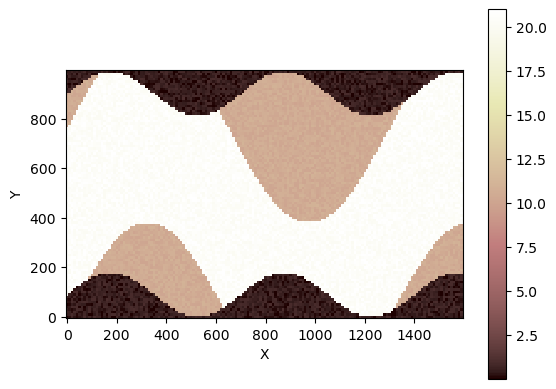

In [5]:
# Setup initial topography in the fashion of a couple of strath terraces
high_terrace = 20.0
low_terrace = 10.0
elev[:] = high_terrace
high_terr_cutout_amp = 380.0
high_terr_cutout_pd = 1300.0
low_terr_cutout_amp = 90.0
low_terr_cutout_pd = 700.0
init_soil_high_terr = 2.0
init_soil_low_terr = 1.0
init_soil_base = 0.5

# Make a sinusoidal cutout into the high terrace
trace_y = high_terr_cutout_amp * np.sin(
    2.0 * np.pi * grid.x_of_node / high_terr_cutout_pd
)
elev[grid.y_of_node < trace_y] = low_terrace
elev[grid.y_of_node > trace_y + 2 * high_terr_cutout_amp] = low_terrace

# ...and the low terrace
trace_y = low_terr_cutout_amp * np.sin(
    2.0 * np.pi * grid.x_of_node / low_terr_cutout_pd
)
elev[grid.y_of_node < trace_y + low_terr_cutout_amp] = 0.0
elev[grid.y_of_node > trace_y + 10 * low_terr_cutout_amp] = 0.0

# add some random noise and smooth it with a moving average
elev[:] += np.random.rand(grid.number_of_nodes)

soil[:] = init_soil_low_terr
soil[elev > low_terrace + 1.0] = init_soil_high_terr
soil[elev < low_terrace] = init_soil_base
rock[:] = elev - soil

imshow_grid(grid, elev)

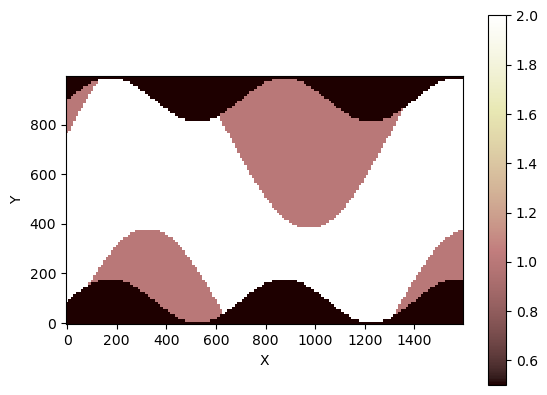

In [6]:
imshow_grid(grid, soil)

In [7]:
# Setup for output, and write first file
router.run_one_step()  # to generate some flow accumulation for the 0th output
weatherer.calc_soil_prod_rate()  # ditto for soil prod rate
frame_number = 0
write_obj(
    base_output_name + str(frame_number).zfill(4) + ".obj",
    grid,
    clobber=True
)
next_output = output_interval

In [8]:
# Run model
for i in range(1, nsteps + 1):
    router.run_one_step()
    weatherer.calc_soil_prod_rate()
    diffuser.run_one_step(dt)
    space.run_one_step(dt)
    if i * dt >= next_output:
        frame_number += 1
        write_obj(
            base_output_name + str(frame_number).zfill(4) + ".obj", grid, clobber=True
        )
        next_output += output_interval

## Installing Blender

The first step is to download and install the Blender application from [https://www.blender.org/download/](https://www.blender.org/download/).

## Reading output files into Blender

...

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>